# Daily-level Prediction for Bike Sharing

This notebook aggregates hourly station data to **daily** level and builds two Random Forest models:

1. **Daily Trip Volume (Regression)**
2. **Daily Peak Shortage `risk_level` (Classification)**

> Replace `DATA_PATH` below with your hourly CSV path (or skip if you already have a `df` DataFrame in memory).

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 200)


## 1. Load hourly data

In [ ]:
# === Configure your data path here ===
DATA_PATH = Path('./hourly_dataset.csv')  # <- change to your file path

try:
    if 'df' in globals() and isinstance(df, pd.DataFrame):
        df_hourly = df.copy()
        print('Using existing DataFrame `df` from memory.')
    elif DATA_PATH.exists():
        df_hourly = pd.read_csv(DATA_PATH)
        print(f'Loaded from {DATA_PATH}')
    else:
        raise FileNotFoundError('Please set DATA_PATH to your hourly CSV or define `df` in memory.')
except Exception as e:
    raise e

# Normalize column names to lower snake_case for consistency
df_hourly.columns = [c.strip().lower().replace(' ', '_') for c in df_hourly.columns]

# Inspect
print(df_hourly.head(3))


## 2. Parse time columns & coerce dtypes

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. 读取包含出行/还车量的主表格
df_hourly = pd.read_csv('0_try2_data/cluster_2024_with_k3.csv')
df_hourly.head()

,station_name,station_id,date,hour_of_day,out_count,in_count,day_of_week,nbDocks,is_weekend,month,...,day_since_start,temperature,humidity,wind_speed,is_rain,cluster,peak_departures,shortage_risk,risk_level,cluster_risk
0,"Abbey Orchard Street, Westminster",BikePoints_864,2024-01-01,0,1.0,0.0,0,29.0,False,1,...,0,8.6,80.3,30.2,1.0,2,9.995935,0.344687,low_risk,2_low_risk
1,"Abbey Orchard Street, Westminster",BikePoints_864,2024-01-01,14,1.0,2.0,0,29.0,False,1,...,0,8.6,80.3,30.2,1.0,2,9.995935,0.344687,low_risk,2_low_risk
2,"Abbey Orchard Street, Westminster",BikePoints_864,2024-01-01,15,0.0,2.0,0,29.0,False,1,...,0,8.6,80.3,30.2,1.0,2,9.995935,0.344687,low_risk,2_low_risk
3,"Abbey Orchard Street, Westminster",BikePoints_864,2024-01-01,16,0.0,1.0,0,29.0,False,1,...,0,8.6,80.3,30.2,1.0,2,9.995935,0.344687,low_risk,2_low_risk
4,"Abbey Orchard Street, Westminster",BikePoints_864,2024-01-01,18,1.0,0.0,0,29.0,False,1,...,0,8.6,80.3,30.2,1.0,2,9.995935,0.344687,low_risk,2_low_risk


In [7]:
import pandas as pd

# 读取原始的按小时数据
df_hourly = pd.read_csv("0_try2_data/cluster_2024_with_k3.csv")

# 统一列名为小写+下划线
df_hourly.columns = [c.strip().lower().replace(" ", "_") for c in df_hourly.columns]

# 删除不需要的成品列
drop_cols = ["peak_departures", "shortage_risk", "risk_level", "cluster_risk"]
df_hourly = df_hourly.drop(columns=[c for c in drop_cols if c in df_hourly.columns])

# 查看清洗后的前几行
print(df_hourly.head())


                        station_name      station_id        date  hour_of_day  \
0  Abbey Orchard Street, Westminster  BikePoints_864  2024-01-01            0   
1  Abbey Orchard Street, Westminster  BikePoints_864  2024-01-01           14   
2  Abbey Orchard Street, Westminster  BikePoints_864  2024-01-01           15   
3  Abbey Orchard Street, Westminster  BikePoints_864  2024-01-01           16   
4  Abbey Orchard Street, Westminster  BikePoints_864  2024-01-01           18   

   out_count  in_count  day_of_week  nbdocks  is_weekend  month  season  \
0        1.0       0.0            0     29.0       False      1  winter   
1        1.0       2.0            0     29.0       False      1  winter   
2        0.0       2.0            0     29.0       False      1  winter   
3        0.0       1.0            0     29.0       False      1  winter   
4        1.0       0.0            0     29.0       False      1  winter   

   is_peak  day_since_start  temperature  humidity  wind_speed

In [8]:
## Step 3. Aggregate hourly data to daily level (with England bank holidays)

import numpy as np
import pandas as pd

# --- prerequisites ---
# df_hourly already loaded and cleaned in previous steps

# 0) enforce dtypes (avoid 'str' arithmetic errors and join issues)
df_hourly["date"] = pd.to_datetime(df_hourly["date"], errors="coerce")

for b in ["is_weekend", "is_rain", "is_peak"]:
    if b in df_hourly.columns:
        df_hourly[b] = (
            df_hourly[b].astype(str).str.lower()
            .map({"true": True, "false": False, "1": True, "0": False})
            .fillna(False).astype(bool)
        )

for n in ["hour_of_day", "out_count", "in_count", "nbdocks", "month",
          "day_of_week", "cluster", "temperature", "humidity", "wind_speed"]:
    if n in df_hourly.columns:
        df_hourly[n] = pd.to_numeric(df_hourly[n], errors="coerce")

# 1) base daily aggregation (totals + first-of-day meta/weather)
grp = ["station_id", "date"]
daily_counts = (
    df_hourly
    .groupby(grp, as_index=False)
    .agg(
        station_name      = ("station_name", "first"),
        daily_out_count   = ("out_count", "sum"),
        daily_in_count    = ("in_count", "sum"),
        is_weekend        = ("is_weekend",  lambda x: bool(pd.Series(x).astype(bool).max())),
        nbdocks           = ("nbdocks", "first"),
        cluster           = ("cluster", "first"),
        season            = ("season", "first"),
        month             = ("month", "first"),
        day_of_week       = ("day_of_week", "first"),
        temperature       = ("temperature", "first"),  # daily variable -> take first
        humidity          = ("humidity", "first"),
        wind_speed        = ("wind_speed", "first"),
        is_rain           = ("is_rain", "first")
    )
)

# 2) weekday peak_departures: sum out_count over hours 7,8,9,16,17,18
df_hourly["hour_of_day"] = pd.to_numeric(df_hourly["hour_of_day"], errors="coerce").astype("Int64")
df_hourly["out_count"]   = pd.to_numeric(df_hourly["out_count"], errors="coerce").fillna(0)

peak_hours   = [7, 8, 9, 16, 17, 18]
weekday_mask = ~df_hourly["is_weekend"].astype(bool)
peak_mask    = df_hourly["hour_of_day"].isin(peak_hours)

peak_weekday = (
    df_hourly[weekday_mask & peak_mask]
    .groupby(grp, as_index=False)
    .agg(peak_departures=("out_count", "sum"))
)

daily = daily_counts.merge(peak_weekday, on=grp, how="left")

# 3) England & Wales bank holidays 2024 -> is_holiday
england_holidays_2024 = [
    "2024-01-01",  # New Year's Day
    "2024-03-29",  # Good Friday
    "2024-04-01",  # Easter Monday
    "2024-05-06",  # Early May bank holiday
    "2024-05-27",  # Spring bank holiday
    "2024-08-26",  # Summer bank holiday
    "2024-12-25",  # Christmas Day
    "2024-12-26",  # Boxing Day
]
holiday_dates = pd.to_datetime(england_holidays_2024)
daily["is_holiday"] = daily["date"].isin(holiday_dates)

# 4) peak_departures rules:
#    - weekends or holidays -> NaN
#    - weekdays without peak rows -> 0
is_weekend_series = daily["is_weekend"].astype(bool)
is_holiday_series = daily["is_holiday"].astype(bool)

daily.loc[~(is_weekend_series | is_holiday_series) & daily["peak_departures"].isna(), "peak_departures"] = 0
daily.loc[(is_weekend_series | is_holiday_series), "peak_departures"] = np.nan

# 5) add day_since_start and daily_trips
min_date = daily["date"].min()
daily["day_since_start"] = (daily["date"] - min_date).dt.days.astype("Int64")
daily["daily_trips"]     = daily["daily_out_count"] + daily["daily_in_count"]

# 6) optional convenience flag and column order
daily["is_non_working_day"] = daily["is_weekend"] | daily["is_holiday"]

cols_order = [
    "station_id","station_name","date","day_since_start",
    "daily_out_count","daily_in_count","daily_trips","peak_departures",
    "is_weekend","is_holiday","is_non_working_day",
    "nbdocks","cluster","season","month","day_of_week",
    "temperature","humidity","wind_speed","is_rain"
]
daily = daily[[c for c in cols_order if c in daily.columns] +
              [c for c in daily.columns if c not in cols_order]]

# minimal check
daily.head(8)


/tmp/ipykernel_361/2233500498.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .fillna(False).astype(bool)


,station_id,station_name,date,day_since_start,daily_out_count,daily_in_count,daily_trips,peak_departures,is_weekend,is_holiday,is_non_working_day,nbdocks,cluster,season,month,day_of_week,temperature,humidity,wind_speed,is_rain
0,BikePoints_1,"River Street , Clerkenwell",2024-01-01,0,0.0,1.0,1.0,NaN,False,True,True,19.0,0,winter,1,0,8.6,80.3,30.2,False
1,BikePoints_1,"River Street , Clerkenwell",2024-01-02,1,7.0,2.0,9.0,3.0,False,False,False,19.0,0,winter,1,1,11.7,83.9,58.7,False
2,BikePoints_1,"River Street , Clerkenwell",2024-01-03,2,12.0,9.0,21.0,9.0,False,False,False,19.0,0,winter,1,2,10.0,80.7,26.5,False
3,BikePoints_1,"River Street , Clerkenwell",2024-01-04,3,13.0,2.0,15.0,8.0,False,False,False,19.0,0,winter,1,3,8.0,86.3,22.2,False
4,BikePoints_1,"River Street , Clerkenwell",2024-01-05,4,10.0,8.0,18.0,5.0,False,False,False,19.0,0,winter,1,4,6.6,84.8,27.6,False
5,BikePoints_1,"River Street , Clerkenwell",2024-01-06,5,11.0,8.0,19.0,NaN,True,False,True,19.0,0,winter,1,5,6.1,79.4,14.2,False
6,BikePoints_1,"River Street , Clerkenwell",2024-01-07,6,15.0,11.0,26.0,NaN,True,False,True,19.0,0,winter,1,6,4.0,69.6,22.0,False
7,BikePoints_1,"River Street , Clerkenwell",2024-01-08,7,13.0,11.0,24.0,8.0,False,False,False,19.0,0,winter,1,0,3.1,65.6,24.8,False


In [9]:
# === shortage_risk, risk_level, cluster_risk ===

# 1) shortage_risk = peak_departures / nbdocks
#    保持 peak_departures 为 NaN 的行也为 NaN
daily["shortage_risk"] = daily["peak_departures"] / daily["nbdocks"]

# 2) 风险等级分类函数（完全照截图）
def risk_level(risk):
    if pd.isna(risk):
        return np.nan
    if risk < 0.5:
        return "low_risk"
    elif risk < 0.9:
        return "medium_risk"
    elif risk < 1.2:
        return "high_risk"
    else:
        return "serious_risk"

daily["risk_level"] = daily["shortage_risk"].apply(risk_level)

# 3) 组合 cluster 和 risk_level
daily["cluster_risk"] = daily["cluster"].astype(str) + "_" + daily["risk_level"]
# minimal check
daily.head(8)


,station_id,station_name,date,day_since_start,daily_out_count,daily_in_count,daily_trips,peak_departures,is_weekend,is_holiday,...,season,month,day_of_week,temperature,humidity,wind_speed,is_rain,shortage_risk,risk_level,cluster_risk
0,BikePoints_1,"River Street , Clerkenwell",2024-01-01,0,0.0,1.0,1.0,NaN,False,True,...,winter,1,0,8.6,80.3,30.2,False,NaN,NaN,NaN
1,BikePoints_1,"River Street , Clerkenwell",2024-01-02,1,7.0,2.0,9.0,3.0,False,False,...,winter,1,1,11.7,83.9,58.7,False,0.157895,low_risk,0_low_risk
2,BikePoints_1,"River Street , Clerkenwell",2024-01-03,2,12.0,9.0,21.0,9.0,False,False,...,winter,1,2,10.0,80.7,26.5,False,0.473684,low_risk,0_low_risk
3,BikePoints_1,"River Street , Clerkenwell",2024-01-04,3,13.0,2.0,15.0,8.0,False,False,...,winter,1,3,8.0,86.3,22.2,False,0.421053,low_risk,0_low_risk
4,BikePoints_1,"River Street , Clerkenwell",2024-01-05,4,10.0,8.0,18.0,5.0,False,False,...,winter,1,4,6.6,84.8,27.6,False,0.263158,low_risk,0_low_risk
5,BikePoints_1,"River Street , Clerkenwell",2024-01-06,5,11.0,8.0,19.0,NaN,True,False,...,winter,1,5,6.1,79.4,14.2,False,NaN,NaN,NaN
6,BikePoints_1,"River Street , Clerkenwell",2024-01-07,6,15.0,11.0,26.0,NaN,True,False,...,winter,1,6,4.0,69.6,22.0,False,NaN,NaN,NaN
7,BikePoints_1,"River Street , Clerkenwell",2024-01-08,7,13.0,11.0,24.0,8.0,False,False,...,winter,1,0,3.1,65.6,24.8,False,0.421053,low_risk,0_low_risk


In [10]:
# 4) 保存结果到新文件
out_path = "0_try2_data/rf_daily.csv"
daily.to_csv(out_path, index=False)
print(f"已保存到: {out_path}")


已保存到: 0_try2_data/rf_daily.csv


In [11]:
import pandas as pd

# 读取前面生成的日级数据
df = pd.read_csv("0_try2_data/rf_daily.csv", parse_dates=["date"])

# 剔除周末和节假日
df_workday = df[(df["is_weekend"] == False) & (df["is_holiday"] == False)]

# 保存新的 CSV
out_path = "0_try2_data/rf_daily_workday.csv"
df_workday.to_csv(out_path, index=False)

print(f"已保存工作日数据到: {out_path}")
print("原始行数:", len(df), "→ 剔除后行数:", len(df_workday))


已保存工作日数据到: 0_try2_data/rf_daily_workday.csv
原始行数: 287497 → 剔除后行数: 199634


1. 日出行量预测模型（回归）

In [24]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# 加载数据
df_reg = pd.read_csv('0_try2_data/rf_daily.csv', parse_dates=['date'])

# 特征工程
def feature_engineering(df_reg):
    # 时间特征
    df_reg['day_of_year'] = df_reg['date'].dt.dayofyear
    df_reg['week_of_year'] = df_reg['date'].dt.isocalendar().week
    df_reg['is_month_start'] = df_reg['date'].dt.is_month_start.astype(int)
    df_reg['is_month_end'] = df_reg['date'].dt.is_month_end.astype(int)
    
    # 滞后特征（过去3天的出行量）
    df_reg = df_reg.sort_values(['station_id', 'date'])
    df_reg['prev_day_trips'] = df_reg.groupby('station_id')['daily_trips'].shift(1)
    df_reg['prev_3day_avg_trips'] = df_reg.groupby('station_id')['daily_trips'].transform(
        lambda x: x.rolling(3, min_periods=1).mean().shift(1))
    
    # 天气交互特征
    df_reg['temp_humidity'] = df_reg['temperature'] * df_reg['humidity']
    df_reg['wind_rain'] = df_reg['wind_speed'] * df_reg['is_rain']
    
    return df_reg.dropna(subset=['prev_day_trips'])

df_reg = feature_engineering(df_reg)

# 特征选择
features_reg = [
    'day_since_start', 'is_weekend', 'is_holiday', 'nbdocks', 'cluster',
    'month', 'day_of_week', 'temperature', 'humidity', 'wind_speed', 'is_rain',
    'day_of_year', 'week_of_year', 'is_month_start', 'is_month_end',
    'prev_day_trips', 'prev_3day_avg_trips', 'temp_humidity', 'wind_rain'
]

target_reg = 'daily_trips'

# 划分数据集
X_reg  = df[features_reg]
y_reg = df_reg[target_reg].copy()

# 分类特征编码
cat_reg = ['cluster', 'month', 'day_of_week']
preproc_reg = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), cat_reg)],
    remainder='passthrough'
)

X_reg_proc = preproc_reg.fit_transform(X_reg)

# 数据集拆分
Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_reg_proc, y_reg, test_size=0.2, random_state=42
)
# ==== 训练 ====
from sklearn.ensemble import RandomForestRegressor



RandomForestRegressor(n_jobs=-1, random_state=42)

In [27]:
# === 训练集和测试集预测 ===
yr_pred_train = model_reg.predict(Xr_train)
yr_pred_test  = model_reg.predict(Xr_test)

reg_metrics = pd.DataFrame({
    'RMSE': [np.sqrt(mean_squared_error(yr_train, yr_pred_train)),
             np.sqrt(mean_squared_error(yr_test,  yr_pred_test))],
    'MAE':  [mean_absolute_error(yr_train, yr_pred_train),
             mean_absolute_error(yr_test,  yr_pred_test)],
    'R²':   [r2_score(yr_train, yr_pred_train),
             r2_score(yr_test,  yr_pred_test)]
}, index=['Train','Test'])
print(reg_metrics)

            RMSE        MAE        R²
Train   7.171451   4.510779  0.976045
Test   19.036440  12.150350  0.827613


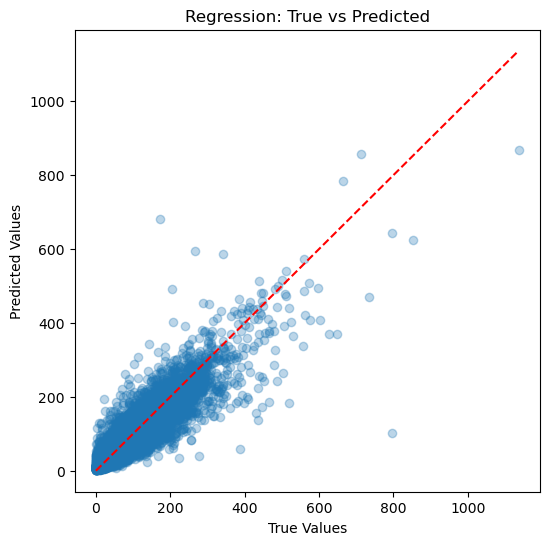

In [28]:
# ==== 可视化：真实 vs 预测、残差、特征重要性 ====
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(yr_test, yr_pred_test, alpha=0.3)
mn, mx = yr_test.min(), yr_test.max()
plt.plot([mn, mx], [mn, mx], 'r--')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Regression: True vs Predicted")
plt.show()


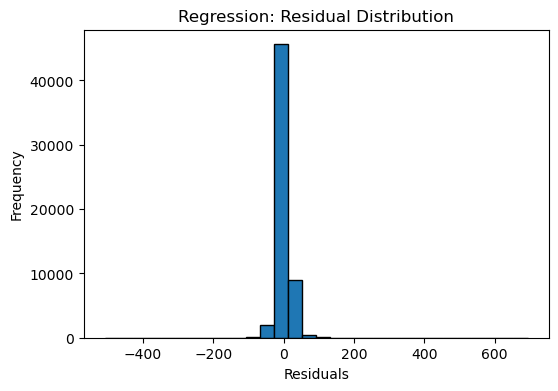

In [29]:
residuals = yr_test - yr_pred_test
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30, edgecolor='k')
plt.xlabel("Residuals"); plt.ylabel("Frequency")
plt.title("Regression: Residual Distribution")
plt.show()

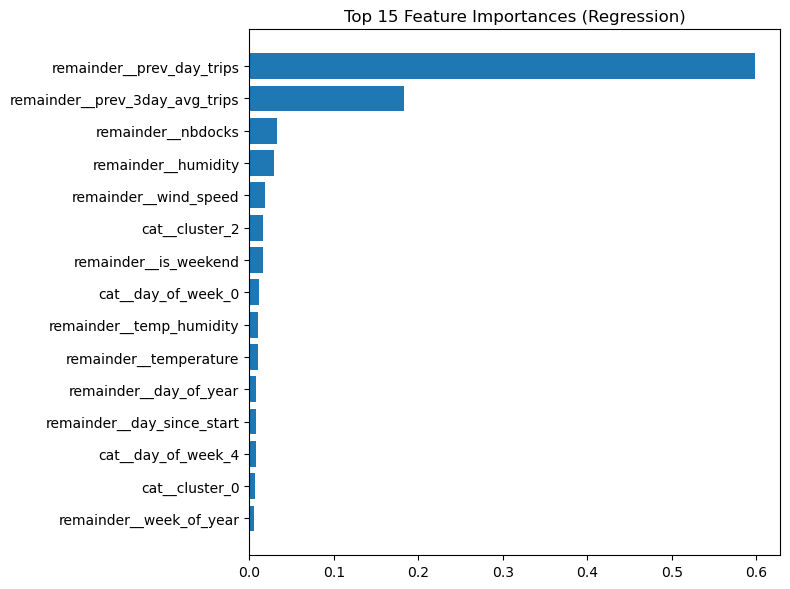

In [30]:
# 特征重要性
feat_names_reg = preproc_reg.get_feature_names_out()
imp_reg = model_reg.feature_importances_
fi_reg = (pd.DataFrame({'feature': feat_names_reg, 'importance': imp_reg})
          .sort_values('importance', ascending=False))

plt.figure(figsize=(8,6))
plt.barh(fi_reg['feature'][:15][::-1], fi_reg['importance'][:15][::-1])
plt.title("Top 15 Feature Importances (Regression)")
plt.tight_layout(); plt.show()

2. 高峰缺车风险预测模型（分类）

In [16]:
pip install imbalanced-learn


Note: you may need to restart the kernel to use updated packages.
